In [1]:
# before everything, import these libraries (Shift-Enter)

from IPython.lib.display import YouTubeVideo
from mesa.batchrunner import BatchRunner, BatchRunnerMP

import xarray as xr

from scripts.model import NetworkedSIR
from scripts.helpers_mesa import mesa_to_xarray

# II. Coding Projects > Covid Simulation


<hr>
&nbsp;

Check the following interactive articles:
- [Covid19 by Nick Case](https://ncase.me/covid-19/)
- [SIRS epidemic model](https://www.complexity-explorables.org/explorables/epidemonic/)
- [Outbreak](Outbreak)
- [Going Critical](https://meltingasphalt.com/interactive/going-critical/)
- [Herd immunity](https://www.complexity-explorables.org/explorables/i-herd-you/)

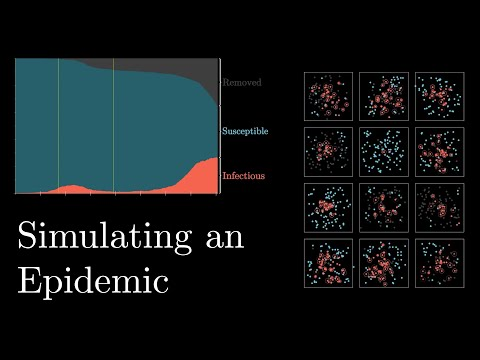

In [2]:
YouTubeVideo('gxAaO2rsdIs',width=560,height=315)

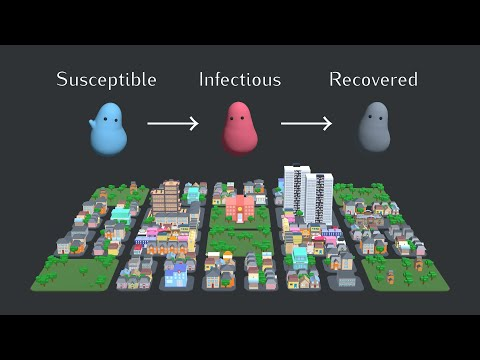

In [3]:
YouTubeVideo('7OLpKqTriio',width=560,height=315)

In [4]:
# variable_parameters = dict(
#     network_type = ['random', 'small world', 'scale free']
# )

# fixed_parameters = dict(
#     num_agents = 50,
#     infectious_period = 10,
#     immunization_period = 30,
#     transmission_probability = 0.3,
#     daily_contact = 1,
#     ini_infection_distri = (0.8, 0.05, 0.15),
#     expected_avg_degree = 3,
# )

# batch_run = BatchRunner(
#     NetworkedSIR,
#     variable_parameters = variable_parameters,
#     fixed_parameters = fixed_parameters,
#     iterations = 4,
#     max_steps = 10,
#     model_reporters={"datacollectors" : lambda model: model.datacollector.model_vars},
# )

# batch_run.run_all()

In [5]:
# res = mesa_to_xarray(batch_run)
# res

In [6]:
# res.sel(network_type='random', Run=0, Step=0).network_metrics

In [7]:
# batch_runMP = BatchRunnerMP(
#     NetworkedSIR,
#     variable_parameters = variable_parameters,
#     fixed_parameters = fixed_parameters,
#     iterations = 2,
#     max_steps = 100,
#     model_reporters={"datacollectors" : lambda model: model.datacollector.model_vars},
# )

# batch_runMP.run_all()

In [8]:
# mesa_to_xarray(batch_runMP)

In [14]:
import numpy as np
import pandas as pd
import networkx as nx

def avg_degree(G):
    return 2 * G.number_of_edges() / G.number_of_nodes()

def degree_distribution(G):
    return np.array(nx.degree_histogram(G))

def network_metrics(G):
    return {
        "avg degree": avg_degree(G),
        "degree distribution": degree_distribution(G),
    }

def generate_data(step, run, n, p):
    G = nx.erdos_renyi_graph(n, p)
    dct = {
        'network_type': 'random',
        'run': run,
        'nb_agents': n,
        'probability': p,
        'recovered': np.random.rand(step),
        # 'infected': np.random.randint(0,100, step),
    }
    dct.update(network_metrics(G))
    return dct


def main(nb_steps):
    lst = []
    for run in range(4):
        for nb_nodes in [10, 20, 50]:
            for probability in [0.1, 0.5, 0.8]:
                dct = generate_data(nb_steps, run, nb_nodes, probability)
                lst.append(dct)

    result = pd.DataFrame(lst)
    indexes = ['network_type', 'run', 'nb_agents', 'probability']
    result.set_index(indexes, inplace=True, drop=True)
    return result

In [15]:
result = main(10)
result.head()

recovered  \
network_type run nb_agents probability                                                      
random       0   10        0.1          [0.1531747093586523, 0.8669106187965888, 0.412...   
                           0.5          [0.565831428243303, 0.38366220749777347, 0.939...   
                           0.8          [0.5371999218778403, 0.2427603855724848, 0.010...   
                 20        0.1          [0.16885306650576892, 0.558857676562019, 0.929...   
                           0.5          [0.33087064660049126, 0.07259516749727546, 0.1...   

                                        avg degree  \
network_type run nb_agents probability               
random       0   10        0.1                 0.8   
                           0.5                 4.8   
                           0.8                 6.8   
                 20        0.1                 2.7   
                           0.5                 9.2   

                                                                     degree distribution  
network_type run nb_agents probability                                                    
random       0   10        0.1                                                 [3, 6, 1]  
                           0.5                                  [0, 0, 1, 1, 1, 4, 2, 1]  
                           0.8                            [0, 0, 0, 0, 0, 1, 4, 2, 2, 1]  
                 20        0.1                                     [0, 6, 6, 1, 3, 3, 1]  
                           0.5          [0, 0, 0, 0, 0, 0, 3, 3, 0, 6, 4, 0, 3, 0, 0, 1]

In [11]:
result.to_xarray()

TypeError: unsupported format string passed to numpy.ndarray.__format__

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
def explode(df, mapping):
    
    new_df = df.reset_index()
    for col, idx in mapping.items():
        new_df.index.rename('_id', inplace=True)
        new_df = new_df.explode(col)
        new_df.insert(1, idx, new_df.groupby('_id').cumcount())
        new_df.reset_index(drop=True, inplace=True)

    idx = list(df.index.names)
    nested_idx = list(mapping.values())

    return new_df.set_index(idx + nested_idx)

In [ ]:
def helper(df, mapping):
    sol = []
    for k,v in mapping.items():
        sol.append(explode(df[k], {k:v}).to_xarray())

    leftover_columns = list(df.columns.difference(mapping.keys()))
    sol.append(df[leftover_columns].to_xarray())
    return sol

In [ ]:
mapping = {'infected': 'step', 'degree distribution': "nb_nodes_with_degree"}
lst = helper(result, mapping)

In [ ]:
xr.combine_by_coords(lst)

<xarray.Dataset>
Dimensions:               (network_type: 1, run: 4, nb_agents: 3, probability: 3, nb_nodes_with_degree: 46, step: 10)
Coordinates:
  * network_type          (network_type) object 'random'
  * run                   (run) int64 0 1 2 3
  * nb_agents             (nb_agents) int64 10 20 50
  * probability           (probability) float64 0.1 0.5 0.8
  * nb_nodes_with_degree  (nb_nodes_with_degree) int64 0 1 2 3 4 ... 42 43 44 45
  * step                  (step) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    avg degree            (network_type, run, nb_agents, probability) float64 ...
    degree distribution   (network_type, run, nb_agents, probability, nb_nodes_with_degree) object ...
    infected              (network_type, run, nb_agents, probability, step) object ...

In [ ]:
sol = xr.combine_by_coords(lst)
sol.sel(network_type='random', run=0, nb_agents=10, probability=0.8)["degree distribution"]

<xarray.DataArray 'degree distribution' (nb_nodes_with_degree: 46)>
array([0, 0, 0, 0, 0, 1, 0, 0, 6, 3, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=object)
Coordinates:
    network_type          <U6 'random'
    run                   int64 0
    nb_agents             int64 10
    probability           float64 0.8
  * nb_nodes_with_degree  (nb_nodes_with_degree) int64 0 1 2 3 4 ... 42 43 44 45

In [ ]:
import cProfile
from pstats import Stats, SortKey

In [ ]:
def test():
    mapping = {'infected': 'step', 'degree distribution': "nb_nodes_with_degree"}
    lst = helper(result, mapping)
    xr.combine_by_coords(lst)

In [ ]:
cProfile.run('test()', "output.pstats")